In [1]:
import tensorflow as tf
import utility.initialize_tf
from utility.data_loading import *
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from utility.display_prediction_results import *
from tensorflow.keras.layers import Dense, Dropout
print(tf.version.VERSION)

2.5.0
2.5.0
2.5.0


In [2]:
#trained_model = "simulation_psf_0.02"
transfer_data = "califa_s_1.0"
testing_data = "nair_abraham_2010"
mesh = 100
validation_split = 0.5
transfer_model_path = f"saved_models\\final_models\\transferred_model_val_split_{validation_split}_mesh_{mesh}"
tune_model_path = f"saved_models\\final_models\\tuned_model_val_split_{validation_split}_mesh_{mesh}"

trained_model_path = f'saved_models\\result_models\\final\\c2\\sim_with_gaussian_noise'


In [5]:
def load_trained_model_tl(model_path, tuning = False):
    model = tf.keras.models.load_model(model_path)
    lr = 0.1
    if not tuning:
        # Pop last layers
        model.pop()
        model.pop()
        model.pop()
        # Freeze base model
        model.trainable=False

        # Create New Model on top
        inputs = tf.keras.Input(shape=(mesh, mesh, 1))
        x = model(inputs, training=False)
        x = Dense(128, activation='relu')(x) # was 128
        x = Dropout(0.5)(x) # added later
        outputs = Dense(2, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()
    else:
        lr = 0.001
    # Compile modified model with new dense layers
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adadelta(learning_rate=lr),
                    metrics=['SparseCategoricalAccuracy'])
    return model
    

# Load Dataset

In [3]:
x_transfer, y_transfer, transfer_metadata = load_hdf5_data(transfer_data)
x_transfer = np.expand_dims(x_transfer, axis=3)
#y_transfer = np.expand_dims(y_transfer, axis=1)
print(y_transfer.shape)
input_shape = x_transfer.shape[1:]
print(input_shape)
sss = StratifiedShuffleSplit(n_splits=3, test_size=validation_split, random_state=2021)
print(sss.get_n_splits(x_transfer, y_transfer))

(79, 100, 100)
(79,)
(100, 100, 1)
3


E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


# Transfer Learning

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=1500, restore_best_weights=True)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', patience=1500, cooldown=10)
for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    train_datagen = create_datagen(x_transfer[train_index])
    val_datagen = create_datagen(x_transfer[val_index])
    transfer_model = load_trained_model_tl(trained_model_path, tuning=False)
    # Train additional layers
    train_history = transfer_model.fit(train_datagen.flow(x_transfer[train_index], y_transfer[train_index], batch_size=128), batch_size=None, epochs=2350,
            verbose=1, validation_data=(x_transfer[val_index], y_transfer[val_index]), callbacks=[early_stopping_callback])
    plot_learning_curve(train_history)
    transfer_model.save(f"{transfer_model_path}_skf={i}.hdf5", overwrite=True)

# Tuning

In [ ]:
# Train whole model for fine tuning.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=1500, restore_best_weights=True)

for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    train_datagen = create_datagen(x_transfer[train_index])
    val_datagen = create_datagen(x_transfer[val_index])
    tuning_model = load_trained_model_tl(f"{transfer_model_path}_skf={i}.hdf5", tuning=True)
    # Train additional layers
    train_history = tuning_model.fit(train_datagen.flow(x_transfer[train_index], y_transfer[train_index], batch_size=128), batch_size=None, epochs=2350,
            validation_data=(x_transfer[val_index], y_transfer[val_index]), callbacks=[early_stopping_callback])
    plot_learning_curve(train_history)
    tuning_model.save(f"{tune_model_path}_skf={i}.hdf5", overwrite=True)

# Results

## Transfered Without Tuning

In [ ]:
transferred_training_results = []
transferred_validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    transferred_model = tf.keras.models.load_model(f"{transfer_model_path}_skf={i}.hdf5")
    #plot_model_results(transferred_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)
    transferred_training_results.append(get_results(transferred_model, x_transfer[train_index], y_transfer[train_index]))
    transferred_validation_results.append(get_results(transferred_model, x_transfer[val_index], y_transfer[val_index]))
average_and_plot_results(transferred_training_results, title="Transfer Learning: C2; Training Confusion Matrix")
average_and_plot_results(transferred_validation_results, title="Transfer Learning: C2; Validation Confusion Matrix")


## With Tuning

In [ ]:
tuned_training_results = []
tuned_validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    tuned_model = tf.keras.models.load_model(f"{tune_model_path}_skf={i}.hdf5")
    #plot_model_results(tuned_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)
    tuned_training_results.append(get_results(tuned_model, x_transfer[train_index], y_transfer[train_index]))
    tuned_validation_results.append(get_results(tuned_model, x_transfer[val_index], y_transfer[val_index]))
average_and_plot_results(tuned_training_results, title="Transfer Learning: C2; Training Confusion Matrix")
average_and_plot_results(tuned_validation_results, title="Transfer Learning: C2; Validation Confusion Matrix")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 147456)            18816     
_________________________________________________________________
dense (Dense)                (None, 128)               18874496  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 18,893,570
Trainable params: 18,874,754
Non-trainable params: 18,816
_________________________________________________________________
Epoch 1/2350
1/1 [==============================] - 3s 3s/step - loss: 0.6925 - sparse_categorical_accuracy: 0

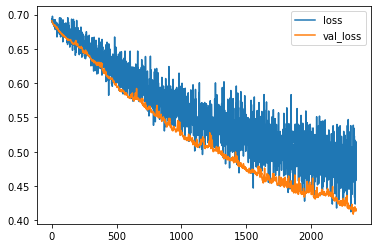

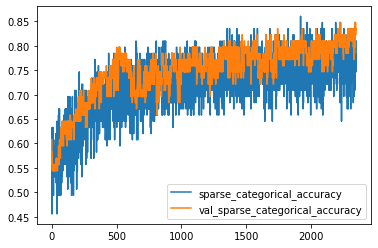

In [6]:
transfer_model_path = f"saved_models\\result_models\\final\\c2\\transferred_model_complete.hdf5"
tune_model_path = f"saved_models\\result_models\\final\\c2\\tuned_model_complete.hdf5"

train_datagen = create_datagen(x_transfer)
transfer_model = load_trained_model_tl(trained_model_path, tuning=False)
# Train additional layers
train_history = transfer_model.fit(train_datagen.flow(x_transfer, y_transfer, batch_size=128), batch_size=None, epochs=2350,
        verbose=1, validation_data=(x_transfer, y_transfer), callbacks=[])
plot_learning_curves(train_history)

transfer_model.save(transfer_model_path, save_traces=True)

Epoch 1/2350
1/1 [==============================] - 1s 737ms/step - loss: 0.4691 - sparse_categorical_accuracy: 0.8101 - val_loss: 0.4142 - val_sparse_categorical_accuracy: 0.8354
Epoch 2/2350
1/1 [==============================] - 0s 135ms/step - loss: 0.4626 - sparse_categorical_accuracy: 0.7975 - val_loss: 0.4142 - val_sparse_categorical_accuracy: 0.8354
Epoch 3/2350
1/1 [==============================] - 0s 133ms/step - loss: 0.5360 - sparse_categorical_accuracy: 0.7342 - val_loss: 0.4142 - val_sparse_categorical_accuracy: 0.8354
Epoch 4/2350
1/1 [==============================] - 0s 123ms/step - loss: 0.4808 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.4142 - val_sparse_categorical_accuracy: 0.8354
Epoch 5/2350
1/1 [==============================] - 0s 130ms/step - loss: 0.4977 - sparse_categorical_accuracy: 0.7089 - val_loss: 0.4142 - val_sparse_categorical_accuracy: 0.8354
Epoch 6/2350
1/1 [==============================] - 0s 133ms/step - loss: 0.4807 - sparse_categorica

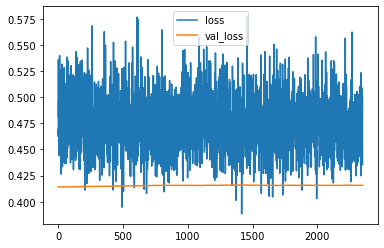

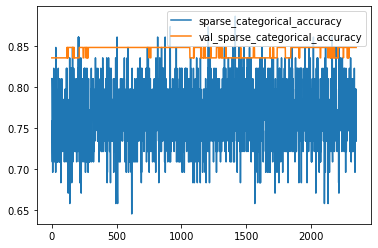

In [7]:
train_datagen = create_datagen(x_transfer)
tuning_model = load_trained_model_tl(transfer_model_path, tuning=True)
# Train additional layers
train_history = tuning_model.fit(train_datagen.flow(x_transfer, y_transfer, batch_size=128), batch_size=None, epochs=2350,
        validation_data=(x_transfer, y_transfer), callbacks=[])
plot_learning_curves(train_history)

tuning_model.save(tune_model_path, save_traces=True)